### **Setup**

In [1]:
import os
import sys

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Move to project root
PROJECT_ROOT = "/content/drive/MyDrive/rl4nlp"
os.chdir(PROJECT_ROOT)
# Make project importable
if PROJECT_ROOT not in sys.path:
  sys.path.append(PROJECT_ROOT)

### **Imports**

In [4]:
from data_utils.load_magpie import load_magpie
from data_utils.load_idioms_in_context import load_idioms_in_context
from data_utils.load_lidioms import load_lidioms

from model.labse import LaBSEEncoder

from experimentation.experiment1_monolingual import experiment1_monolingual
from experimentation.experiment2_crosslingual import experiment2_crosslingual
from experimentation.experiment3_lidioms import experiment3_lidioms

from experimentation.metrics import (
    cosine_sim,
    random_pair_similarity,
    pca_analysis,
)

from experimentation.plots import (
    plot_similarity_distributions,
    plot_precision_at_k,
    plot_pca,
    plot_aligned_vs_random,
    plot_difference_histogram,
    plot_pca_crosslingual,
    plot_literal_vs_idiomatic_difference,
    plot_pairwise_similarity_scatter,
)

import numpy as np


In [5]:
encoder = LaBSEEncoder()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### **Experiment 1: Monolingual Distinction (MAGPIE)**

In [6]:
print("\n=== Experiment 1: Monolingual Distinction (MAGPIE) ===")

df_magpie = load_magpie("data/magpie.tsv")

sentences = df_magpie["sentence"].tolist()
labels = df_magpie["usage"].values

emb_magpie = encoder.encode(sentences)

stats_exp1 = experiment1_monolingual(
  embeddings=emb_magpie,
  df_magpie=df_magpie,
)


=== Experiment 1: Monolingual Distinction (MAGPIE) ===


Batches:   0%|          | 0/1390 [00:00<?, ?it/s]

In [7]:
print("\n--- Similarity means ---")
for k, v in stats_exp1["means"].items():
    print(f"{k}: {v:.3f}")

print("\n--- Effect sizes (Cohen's d) ---")
for k, v in stats_exp1["effect_sizes"].items():
    print(f"{k}: {v:.3f}")

print("\n--- Mann–Whitney tests ---")
for name, (u, p) in stats_exp1["statistics"].items():
    print(f"{name}: U={u:.1f}, p={p:.2e}")

print("\n--- Precision@k by usage ---")
for usage, vals in stats_exp1["precision_at_k_by_usage"].items():
    print(f"{usage}:")
    for k, v in vals.items():
        print(f"  Precision@{k}: {v:.3f}")

print("\n--- PCA / clustering ---")
print("Explained variance (PC1, PC2):",
      stats_exp1["pca"]["explained_variance"])
print("Total explained variance:",
      stats_exp1["pca"]["total_variance"])
print("Silhouette score:",
      f'{stats_exp1["pca"]["silhouette_score"]:.3f}')


--- Similarity means ---
fig_fig: 0.131
lit_lit: 0.145
fig_lit: 0.129

--- Effect sizes (Cohen's d) ---
d_fig: 0.025
d_lit: 0.192

--- Mann–Whitney tests ---
fig_vs_cross: U=12628318.5, p=1.87e-01
lit_vs_cross: U=13770383.0, p=6.78e-19

--- Precision@k by usage ---
figurative:
  Precision@1: 0.852
  Precision@5: 0.995
  Precision@10: 1.000
literal:
  Precision@1: 0.543
  Precision@5: 0.910
  Precision@10: 0.969

--- PCA / clustering ---
Explained variance (PC1, PC2): [0.02699394 0.0204496 ]
Total explained variance: 0.047443546
Silhouette score: 0.003


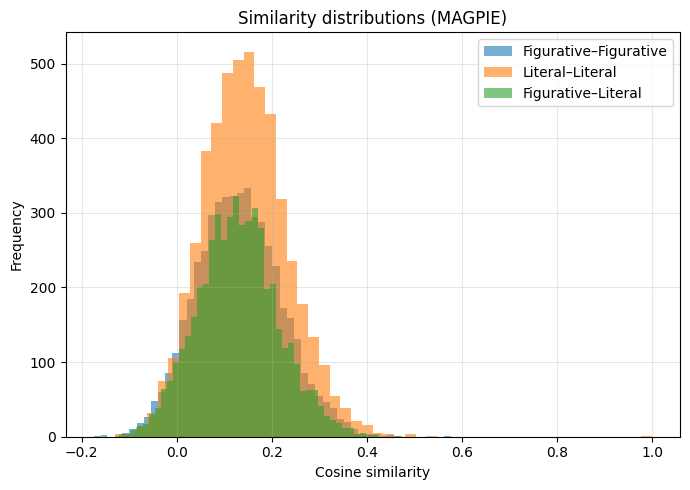

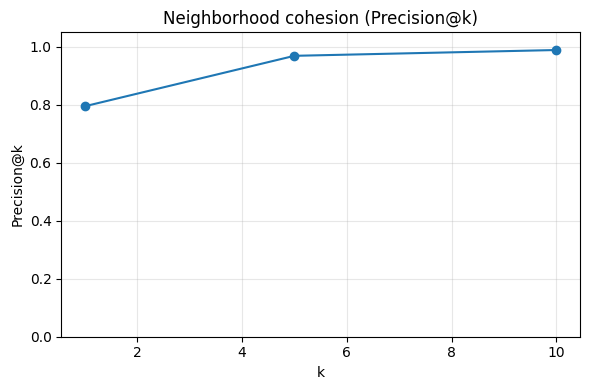

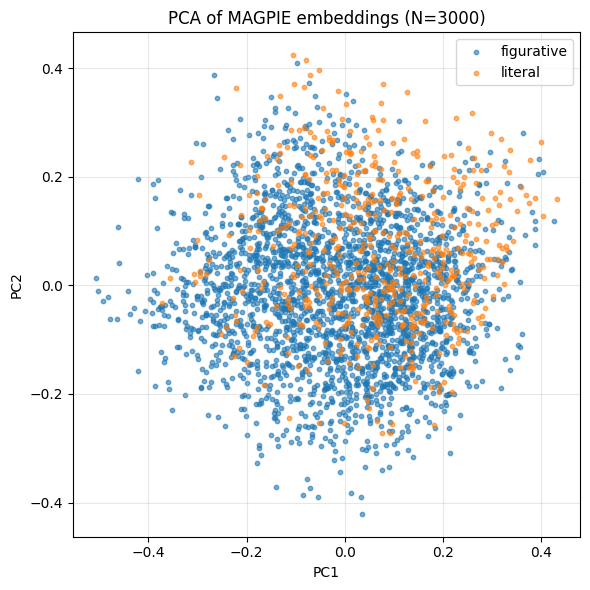

In [8]:
# Similarity distributions

plot_similarity_distributions(
  stats_exp1["similarities"]["fig"],
  stats_exp1["similarities"]["lit"],
  stats_exp1["similarities"]["cross"],
)

# Precision@k
plot_precision_at_k(stats_exp1["precision_at_k"])

# PCA
from experimentation.metrics import pca_analysis

N_PCA = 3000

emb_pca = emb_magpie[:N_PCA]
labels_pca = labels[:N_PCA]

pca = pca_analysis(emb_pca)
plot_pca(
  pca["X_proj"],
  labels=labels_pca,
  title="PCA of MAGPIE embeddings (N=3000)"
)

### **Experiment 2: Cross-lingual Alignment**

In [9]:
print("\n=== Experiment 2: Cross-lingual Alignment ===")

df_idioms = load_idioms_in_context(
  ru_path="data/idioms_in_context-test.ruru-enus.ruru",
  en_path="data/idioms_in_context-test.ruru-enus.enus",
)

emb_ru = encoder.encode(df_idioms["ru_sentence"].tolist())
emb_en = encoder.encode(df_idioms["en_sentence"].tolist())

stats_exp2 = experiment2_crosslingual(
    emb_ru=emb_ru,
    emb_en=emb_en,
    sentences_ru=df_idioms["ru_sentence"].tolist(),
    sentences_en=df_idioms["en_sentence"].tolist(),
)



=== Experiment 2: Cross-lingual Alignment ===


Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [10]:
print("\n--- Similarity statistics ---")
print(f"Aligned RU–EN mean similarity: {stats_exp2['aligned_mean']:.3f}")
print(f"Random RU–EN mean similarity:  {stats_exp2['random_mean']:.3f}")

print("\n--- Effect size ---")
print(f"Cohen's d: {stats_exp2['cohens_d']:.3f}")

print("\n--- Retrieval accuracy ---")
for k, acc in stats_exp2["retrieval"].items():
    print(f"Precision@{k}: {acc:.3f}")

print("\n--- TF-IDF baseline ---")
print(f"TF-IDF aligned mean: {stats_exp2['tfidf_aligned_mean']:.3f}")
print(f"TF-IDF random mean:  {stats_exp2['tfidf_random_mean']:.3f}")


--- Similarity statistics ---
Aligned RU–EN mean similarity: 0.793
Random RU–EN mean similarity:  0.172

--- Effect size ---
Cohen's d: 7.366

--- Retrieval accuracy ---
Precision@1: 1.000
Precision@5: 1.000
Precision@10: 1.000

--- TF-IDF baseline ---
TF-IDF aligned mean: 0.001
TF-IDF random mean:  0.000


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(
    df_idioms["ru_sentence"].tolist() +
    df_idioms["en_sentence"].tolist()
)

X_ru = X[:len(df_idioms)]
X_en = X[len(df_idioms):]

tfidf_sim = cosine_similarity(X_ru, X_en).diagonal()
tfidf_sim.mean()

np.float64(0.0012955078925551383)

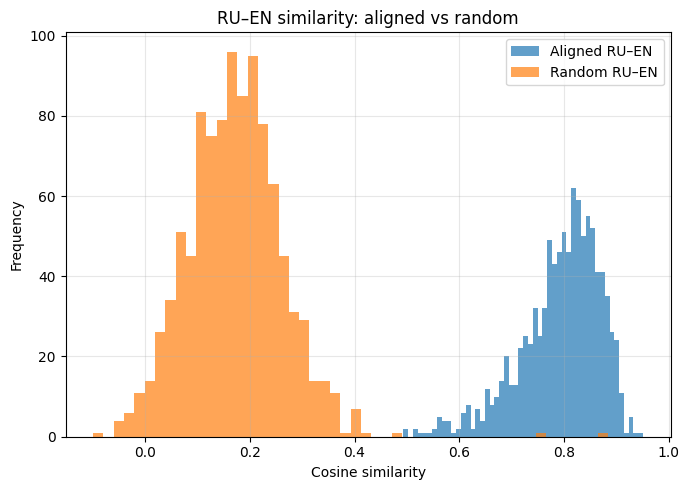

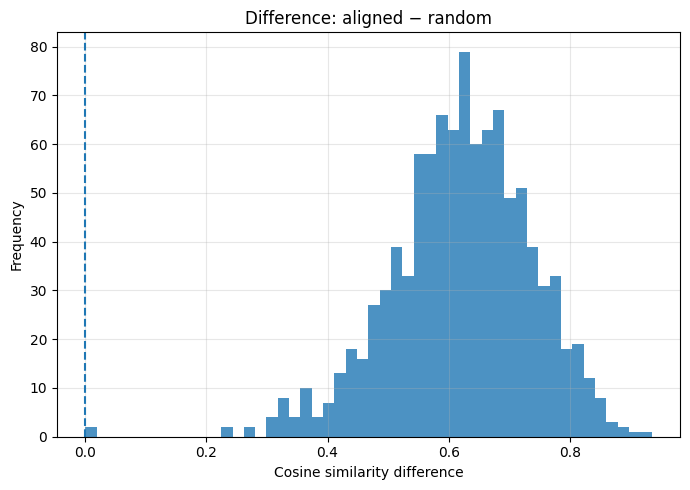

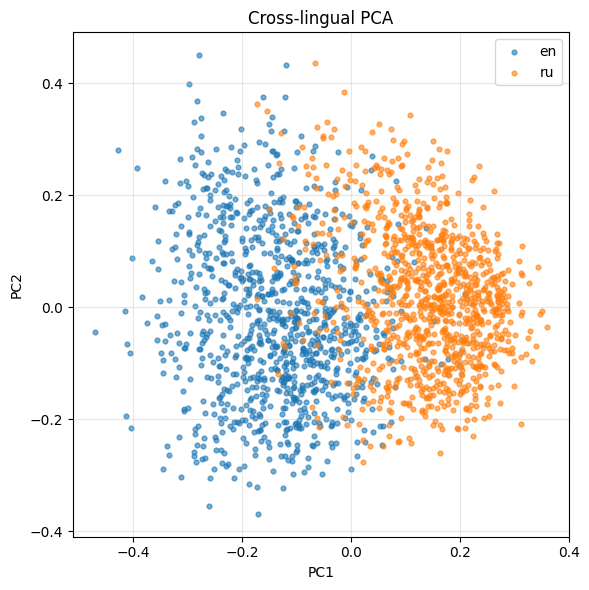

In [12]:
# Similarity distributions
aligned = cosine_sim(emb_ru, emb_en)
random = random_pair_similarity(emb_ru, emb_en)

plot_aligned_vs_random(
  aligned,
  random,
  title="RU–EN similarity: aligned vs random",
)

plot_difference_histogram(aligned, random)
# PCA (cross-lingual)
N_PCA = 1000
X = np.vstack([
  emb_ru[:N_PCA],
    emb_en[:N_PCA],
])

lang_labels = np.array(["ru"] * N_PCA + ["en"] * N_PCA)

pca = pca_analysis(X)
plot_pca_crosslingual(pca["X_proj"], lang_labels)

### **Experiment 3. Semantic vs Lexical Preference (LIdioms)**

In [13]:
print("\n=== Experiment 3: Semantic vs Lexical Preference (LIdioms)===")

df_lidioms = load_lidioms("data/lidioms_full.csv")

emb_ru = encoder.encode(df_lidioms["idiom_ru"].tolist())
emb_idiomatic = encoder.encode(df_lidioms["definition_en"].tolist())
emb_literal = encoder.encode(df_lidioms["literal_en"].tolist())

stats_exp3, detailed_exp3 = experiment3_lidioms(
  emb_ru=emb_ru,
  emb_idiomatic=emb_idiomatic,
  emb_literal=emb_literal,
  df_lidioms=df_lidioms,

)


=== Experiment 3: Semantic vs Lexical Preference (LIdioms)===


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [14]:
print("\n=== Experiment 3: Semantic vs Lexical Preference (LIdioms) ===")

print("\n--- Similarity means ---")
print(f"RU → EN definition: {stats_exp3['idiomatic_mean']:.3f}")
print(f"RU → EN literal:   {stats_exp3['literal_mean']:.3f}")

print("\n--- Preference analysis ---")
print(
    f"Mean difference (literal − idiomatic): "
    f"{stats_exp3['difference_mean']:.3f}"
)

print(
    f"Proportion preferring literal: "
    f"{stats_exp3['prop_prefers_literal']:.3f}"
)

print("\n--- Statistical test ---")
u_stat, p_value = stats_exp3["u_test"]
print(f"Mann–Whitney U = {u_stat:.1f}, p = {p_value:.2e}")
print(f"Cohen's d = {stats_exp3['cohens_d']:.3f}")


=== Experiment 3: Semantic vs Lexical Preference (LIdioms) ===

--- Similarity means ---
RU → EN definition: 0.361
RU → EN literal:   0.812

--- Preference analysis ---
Mean difference (literal − idiomatic): 0.452
Proportion preferring literal: 0.990

--- Statistical test ---
Mann–Whitney U = 10399.0, p = 5.40e-33
Cohen's d = 3.273


In [15]:
print(stats_exp3.keys())

dict_keys(['idiomatic_mean', 'literal_mean', 'difference_mean', 'prop_prefers_literal', 'u_test', 'cohens_d'])


In [16]:
print("\n--- Detailed results (head) ---")
display(detailed_exp3.head())


--- Detailed results (head) ---


,definition_en,literal_en,idiom_ru,sim_idiomatic,sim_literal,difference,prefers_literal
0,let's return to our subject,return to our rams,вернемся к нашим баранам,0.744565,0.895208,0.150643,True
1,heavly rain,pours like from a bucket,льёт как из ведра,0.528424,0.843811,0.315387,True
2,"fool, trick",lead by the nose,водить за нос,0.357555,0.840246,0.482691,True
3,guy who can do everything (in a good way),master of all hands,мастер на все руки,0.510590,0.903256,0.392666,True
4,to make someone feel very frightened,hairs upright,волосы дыбом,0.298957,0.792407,0.493450,True


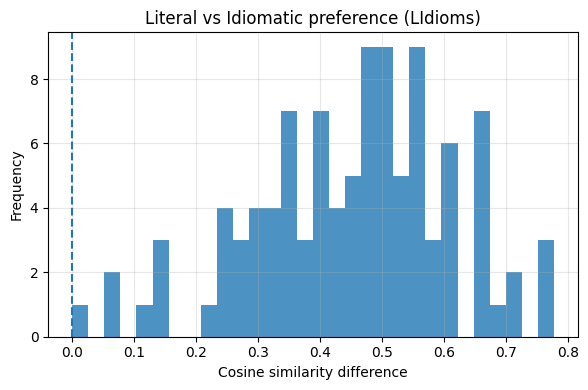

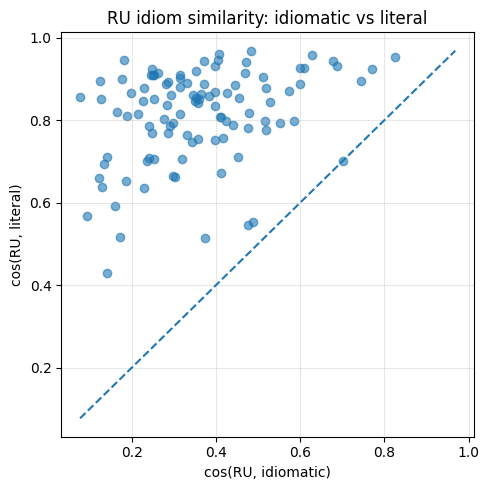

In [17]:
from experimentation.metrics import cosine_sim
from experimentation.metrics import cosine_sim

sim_idiomatic = cosine_sim(emb_ru, emb_idiomatic)
sim_literal = cosine_sim(emb_ru, emb_literal)

# Difference: literal − idiomatic
diff = sim_literal - sim_idiomatic

# --- Visualizations ---
from experimentation.plots import (
  plot_literal_vs_idiomatic_difference,
  plot_pairwise_similarity_scatter,
)

# 1) Histogram of differences (MAIN FIGURE)
plot_literal_vs_idiomatic_difference(
  diff,
  title="Literal vs Idiomatic preference (LIdioms)"
)

# 2) Pairwise scatter (SUPPORTING FIGURE)
plot_pairwise_similarity_scatter(
  sim_idiomatic,
  sim_literal,
  title="RU idiom similarity: idiomatic vs literal"
)

# **Summary table**

In [18]:
import pandas as pd

summary = pd.DataFrame({
    "Experiment": [
        "Exp1: Monolingual (Fig vs Cross)",
        "Exp1: Monolingual (Lit vs Cross)",
        "Exp2: Cross-lingual Alignment",
        "Exp3: Literal vs Idiomatic"
    ],
    "Main metric": [
        "Cohen's d",
        "Cohen's d",
        "Cohen's d",
        "Cohen's d"
    ],
    "Value": [
        stats_exp1["effect_sizes"]["d_fig"],
        stats_exp1["effect_sizes"]["d_lit"],
        stats_exp2["cohens_d"],
        stats_exp3["cohens_d"]
    ],
    "Interpretation": [
        "Weak separation",
        "Moderate separation",
        "Very strong alignment",
        "Literal preferred"
    ]
})

display(summary)

,Experiment,Main metric,Value,Interpretation
0,Exp1: Monolingual (Fig vs Cross),Cohen's d,0.024583,Weak separation
1,Exp1: Monolingual (Lit vs Cross),Cohen's d,0.191815,Moderate separation
2,Exp2: Cross-lingual Alignment,Cohen's d,7.365849,Very strong alignment
3,Exp3: Literal vs Idiomatic,Cohen's d,3.272766,Literal preferred


In [20]:
import pandas as pd

exp1_rows = [
    {
        "comparison": "fig_vs_cross",
        "mean_similarity": stats_exp1["means"]["fig_fig"],
        "cohens_d": stats_exp1["effect_sizes"]["d_fig"],
        "p_value": stats_exp1["statistics"]["fig_vs_cross"][1],
    },
    {
        "comparison": "lit_vs_cross",
        "mean_similarity": stats_exp1["means"]["lit_lit"],
        "cohens_d": stats_exp1["effect_sizes"]["d_lit"],
        "p_value": stats_exp1["statistics"]["lit_vs_cross"][1],
    },
]

df_exp1 = pd.DataFrame(exp1_rows)
df_exp1.to_csv("results/exp1_summary.csv", index=False)


In [22]:
df_exp2 = pd.DataFrame([{
    "aligned_mean": stats_exp2["aligned_mean"],
    "random_mean": stats_exp2["random_mean"],
    "cohens_d": stats_exp2["cohens_d"],
    "retrieval_p@1": stats_exp2["retrieval"][1],
    "retrieval_p@5": stats_exp2["retrieval"][5],
    "retrieval_p@10": stats_exp2["retrieval"][10],
    "tfidf_aligned_mean": stats_exp2.get("tfidf_aligned_mean"),
    "tfidf_random_mean": stats_exp2.get("tfidf_random_mean"),
}])

df_exp2.to_csv("results/exp2_summary.csv", index=False)


In [21]:
df_exp3 = pd.DataFrame([{
    "idiomatic_mean": stats_exp3["idiomatic_mean"],
    "literal_mean": stats_exp3["literal_mean"],
    "difference_mean": stats_exp3["difference_mean"],
    "prop_prefers_literal": stats_exp3["prop_prefers_literal"],
    "cohens_d": stats_exp3["cohens_d"],
    "p_value": stats_exp3["u_test"][1],
}])

df_exp3.to_csv("results/exp3_summary.csv", index=False)
